In [5]:
# Author: Muhammad Hammad Khokhar
# Date: 2023-12-19
# Version: 0.1

# Waste Detection Model - Xception - CNN

# **Table of Contents**

1. [Introduction](#introduction)
2. [Problem Statement](#problem-statement)
    - [What is the problem you are trying to solve?](#what-is-the-problem-you-are-trying-to-solve)
    - [What is the context of the problem?](#what-is-the-context-of-the-problem)
3. [Pipeline](#3-pipeline)
    - [Import Libraries](#import-libraries)
    - [Import Dataset](#load-data)
        - Dataset Creation
    - [Image Visualization](#image-visualization)
    - [Image Pre-Processing](#Image-preprocessing)
    - [Feature Engineering](#feature-engineering)
    - [Building Deep Learning Model](#Building-Deep-Learning-Model)
    - [Model Making](#model-making)
    - [Model Training](#model-training)
    - [Model Evaluation](#evaluation)
    - [Model Testing](#evaluation)
    - [Conclusion](#conclusion)
    - [References](#references)

# **1. Introduction**

> Aim of this program is to help individuals/companies/households to know in terms of what type of waste goes in which bin. Specially people from non-eu countries or where waste management is not a concept can benefit from this program. Also, the new migrants in EU can benefit from this and residents too because they also do not know everytime what goes where as the packages lack in terms of mentioning clearly. We aim to help reduce global pollution with right waste management classification. We are using [Waste Classification Dataset](https://www.kaggle.com/datasets/techsash/waste-classification-data/data) for this project.

# **2. Problem Statement**

##### What is the problem you are trying to solve?

> There has been increased issue of climate sustainability where waste management plays a vital role. Companies/Individuals do have different bins for waste management but the problem lies in identification of what goes where and due to lack of labelling on the products people struggle to manage waste. (Oliveira, 2023)

##### What are the potential impacts of this project?

> People will be able to classify the difference between organic and recycleable waste/objects. This program can impact millions of businesses and houses with classification of waste to help them throw in right bin, that will aid in waste management globally. 


# **3. Pipeline**

## Import Libraries

Importing the necessary libraries for the project

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2

## Import Dataset

Here we set the paths of images directory which will be used to generate datasets

In [7]:
# Path Configuration For Datasets
trainImagesPath = "/DATASET/TRAIN/"
testImagesPath = "/DATASET/TEST/"

### Datasets Creation From Images Directory & Split

In this section, we will create the datasets from images directory and split training set for validation. Our image size will be `180x180`

In [8]:
# Parameters configuration
sizeOfImage = (180, 180) # 180 x 180 pixels
batchSizeOfImage = 32 # 32 images per batch
heightOfImage = 180 # 180 pixels
widthOfImage = 180 # 180 pixels
shapeOfInput = (heightOfImage, widthOfImage, 3)

In [9]:
print("TRAINING & VALIDATION DATASET CREATION")
# Training Dataset
trainImagesDS, valImagesDS = tf.keras.preprocessing.image_dataset_from_directory(
    trainImagesPath,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(heightOfImage, widthOfImage),
    batch_size=batchSizeOfImage)

print("TEST SET DATASET CREATION")
# Test Dataset
testImagesDS = tf.keras.preprocessing.image_dataset_from_directory(
    testImagesPath,
    seed=123,
    image_size=(heightOfImage, widthOfImage),
    batch_size=batchSizeOfImage)

TRAINING & VALIDATION DATASET CREATION
Found 22564 files belonging to 2 classes.
Using 18052 files for training.
Using 4512 files for validation.
TEST SET DATASET CREATION
Found 2513 files belonging to 2 classes.


Total images we have are `22,564` out of which `18,052` will be used for training and `4,512` for validation.

# Image Visualization



We found total 2 classes ['O', 'R']
Definition 'O': Organic and 'R': Recycle


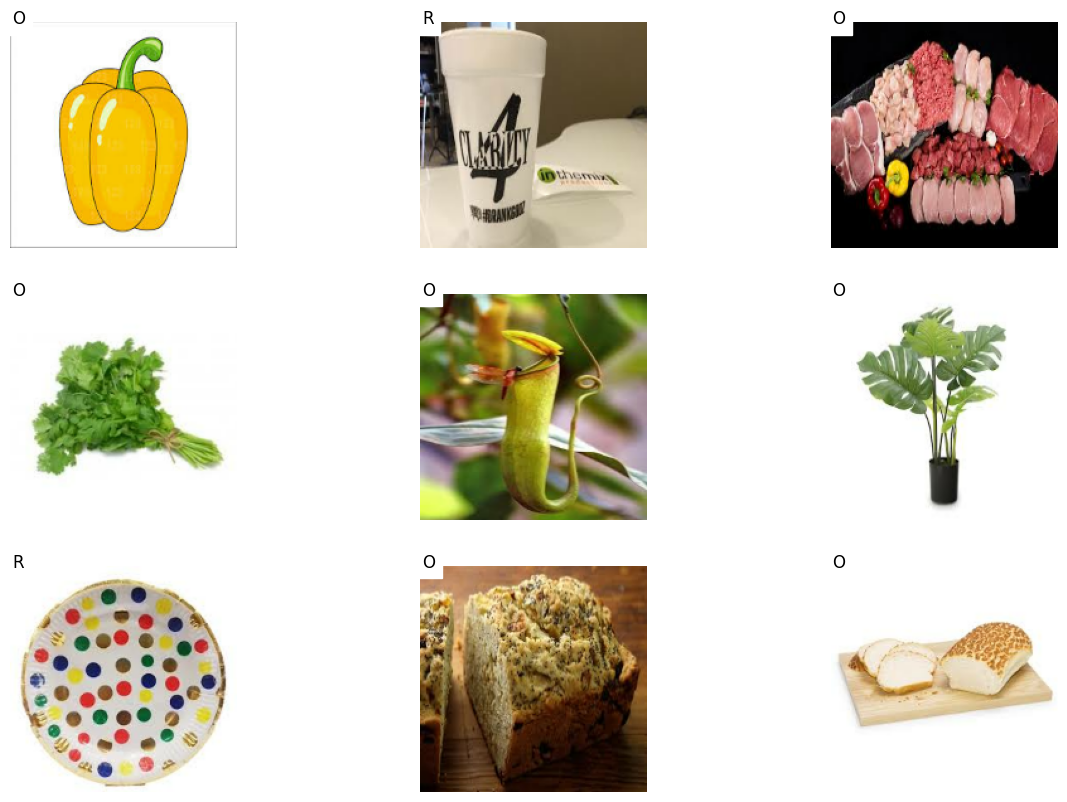

In [10]:
wasteClassTypes = trainImagesDS.class_names
print(f"We found total {len(wasteClassTypes)} classes {wasteClassTypes}")
print(f"Definition '{wasteClassTypes[0]}': Organic and '{wasteClassTypes[1]}': Recycle")

# We will display some of the images from the dataset
plt.figure(figsize=(15,10))
for images, labels in trainImagesDS.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        index=np.random.randint(15000)
        plt.text(1, 1, str(wasteClassTypes[labels[i]]), color='black', backgroundcolor='white', fontsize=12)
        plt.axis("off")

## Image Pre-Processing

We will start pre-processing our images to make them fit for our neural network.

### Data Augmentation

We will generate artificially more images because our dataset is not large, that aids in slow down/avoid the data overfitting. We will do random horizontal sampling and random flipping, minor rotation, contrast adjustments, brightness adjustments which will aid in exposing our model to different aspects.

In [11]:
# Layers creation and hyperparameter tuning
imagesAugmentationLayer = {
    layers.RandomFlip(mode="horizontal",input_shape=shapeOfInput), #left-right flip
    layers.RandomRotation(factor=0.3, seed=None),
    layers.RandomContrast(factor=0.2, seed=None),
    layers.RandomBrightness(factor=0.2)
}

# Augmentation processor
def imageAugmentation(images):
    for layer in imagesAugmentationLayer:
        # apply augmentation on each image
        images = layer(images)
    # returns augmentated images    
    return images

Now we will display the samples and see what are the results after applying `imageAugmentation` repeatedly to first few images.

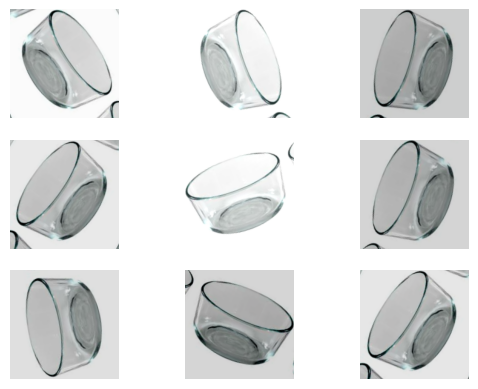

In [12]:
for images, _ in trainImagesDS.take(1):
    for i in range(9):
        processedImages = imageAugmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(processedImages[0]).astype("uint8"))
        plt.axis("off")

We have to check images RGB channel values range because we need to make sure the input values are small for our neural network.

In [13]:
# RBG Channel (top-left corner)
rgb_values = processedImages[0][0,0] # 0,0 (x,y)
print(f'RGB values: {rgb_values}')

RGB values: [194.40904 203.2274  200.22687]


## Feature Engineering

### Feature Scaling
We have seen that our images have `0-255` RBG range which will not be feasible for our neural network and requires rescaling layer to adjust the channel to `0-1`. (K.a., 2019)

Our approach will do image augmentation synchronously with model execution which means GPU acceleartion will be used.

> Code is moved to `Model Building` to run through each image while training

### Dataset Performance Configuration
We will apply image augmentation to training dataset and let autotuning decide the optimal number for prefetching with aids in GPU usage
* Image = Independent Variable
* Label = Target

In [14]:
# dynamic tuning in the background to find the optimal number of element to prefetch
AUTOTUNE = tf.data.experimental.AUTOTUNE
# perform image augmentation
trainImagesDS = trainImagesDS.map(lambda image, label:(imageAugmentation(image), label),  num_parallel_calls=AUTOTUNE)
# sampling in memory to maximize GPU usage
trainImagesDS = trainImagesDS.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valImagesDS = valImagesDS.cache().prefetch(buffer_size=AUTOTUNE)

## Building Deep Learning Model

We will build **Xception CNN** which is `Extreme version of Inception` with a modified depthwise separable convolution to develop understanding of the image classfication. (François Chollet, 2017)

In [15]:
# Model creation
"""
Xception network
iA = images augmented
Hyperparameter tuning is done for each layer with explanation
"""
def nextGenModel(imageSizes, totalClasses):
    # Image input sizes
    inputs = keras.Input(shape=imageSizes)
    
    # Apply augmentation
    iA = imageAugmentation(inputs)
    
    # Rescaling features of images to new range of 0-1 from 0-225 rbg channel
    iA = layers.Rescaling(1./255)(iA)
    
    # Convolution
    """
    We add 128 filters which will scan over an image in order to condense/extract 
    the relevant information inside that image to make an output classification

    Filter specs: 128 Filters and moves 2 block at a time with 3 kernal
    """
    iA = layers.Conv2D(128, 3, strides=2, padding="same")(iA)
    
    # Normalization increases NN stability
    iA = layers.BatchNormalization()(iA)
    
    # Activation
    """
    We convert any negative values to 0 that allows us preserve positive value
    """
    iA = layers.Activation("relu")(iA)

    # ResNet to mitigate vanishing gradients problem - storing current state of activations in previous layers
    previousLayersActivationBlock = iA

    """
    loop through size of filters 256, 512, 728
    """
    for filterSize in [256, 512, 728]:
        iA = layers.Activation("relu")(iA)
        """
        SeparableConv2D - spatial convolution on each channel of given filter size
        """
        iA = layers.SeparableConv2D(filterSize, 3, padding="same")(iA)
        iA = layers.BatchNormalization()(iA)

        iA = layers.Activation("relu")(iA)
        iA = layers.SeparableConv2D(filterSize, 3, padding="same")(iA)
        iA = layers.BatchNormalization()(iA)

        """
        Goes through our images and condences them
        Returns back the value after relu activation, scans through the image value and condence the information
        """
        iA = layers.MaxPooling2D(3, strides=2, padding="same")(iA)

        # Projection shorcut
        """
        Matches the dimensions by 1 x 1 to learn linear projection of our ResNet activation block
        """
        residual = layers.Conv2D(filterSize, 1, strides=2, padding="same")(
            previousLayersActivationBlock
        )
        
        # shortcut connection with iA output
        iA = layers.add([iA, residual])
        
        # storing current state of activations for next block
        previousLayersActivationBlock = iA

    # Final Layers with 1024 filters
    iA = layers.SeparableConv2D(1024, 3, padding="same")(iA)
    """
    Previous activation layer output normalization
    """
    iA = layers.BatchNormalization()(iA)
    iA = layers.Activation("relu")(iA)

    # Each feature map average calculation (data dimensions reduction)
    iA = layers.GlobalAveragePooling2D()(iA)
    
    # Use single unit (sigmod) when classes are 2 otherwise units equal to classes (multiclass)
    if totalClasses == 2:
        units = 1
    else:
        units = totalClasses

    # Prevent of overfitting by setting input units to 0 during each update while training
    iA = layers.Dropout(0.25)(iA)
    
    # Final classification
    outputs = layers.Dense(units, activation=None)(iA)
    return keras.Model(inputs, outputs)

### Model Making

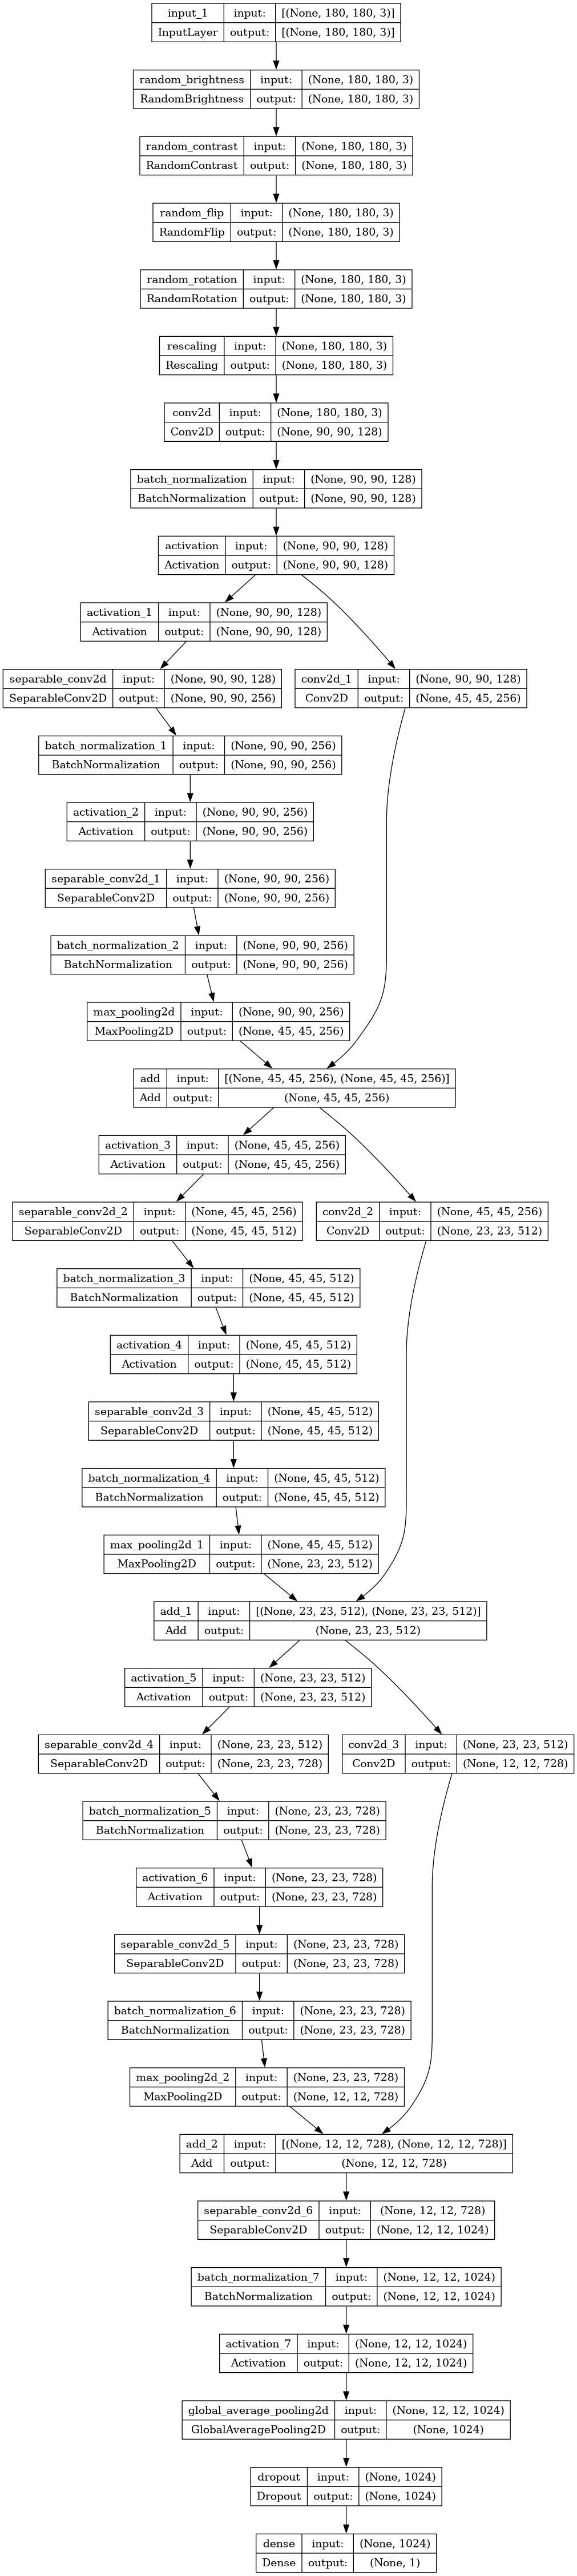

In [16]:
# Param Configurations
strucutre = "TB" # Model plot top-to-bottom
classesInDataset = 2
modelPlotDensity = 96

# Generation of new model
xcepModel = nextGenModel(imageSizes=sizeOfImage + (3,), totalClasses=classesInDataset)
# Model visualization
keras.utils.plot_model(
    xcepModel, show_shapes=True, show_layer_names=True, rankdir=strucutre, expand_nested=True, dpi=modelPlotDensity
)

### Model Training
We will train our Xception network model with training set

In [66]:
# No of times trainig process will run through training data
epochs = 10

# Compile model
xcepModel.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# checkpoint to save model 
modelCallbacks = [keras.callbacks.ModelCheckpoint("interval_{epoch}.keras")]

# Training
xcepModel.fit(
    trainImagesDS,  
    callbacks=modelCallbacks,
    epochs=epochs,
    validation_data=valImagesDS
)

Epoch 1/10
565/565 [==============================] - 198s 336ms/step - loss: 0.2008 - accuracy: 0.9191 - val_loss: 0.2510 - val_accuracy: 0.9060
Epoch 2/10
565/565 [==============================] - 196s 347ms/step - loss: 0.1957 - accuracy: 0.9228 - val_loss: 0.2606 - val_accuracy: 0.9071
Epoch 3/10
565/565 [==============================] - 196s 347ms/step - loss: 0.1919 - accuracy: 0.9267 - val_loss: 0.3146 - val_accuracy: 0.8834
Epoch 4/10
565/565 [==============================] - 196s 347ms/step - loss: 0.1915 - accuracy: 0.9254 - val_loss: 0.2542 - val_accuracy: 0.9040
Epoch 5/10
565/565 [==============================] - 196s 347ms/step - loss: 0.1918 - accuracy: 0.9223 - val_loss: 0.2641 - val_accuracy: 0.9014
Epoch 6/10
565/565 [==============================] - 196s 347ms/step - loss: 0.1882 - accuracy: 0.9232 - val_loss: 0.2173 - val_accuracy: 0.9229
Epoch 7/10
565/565 [==============================] - 196s 347ms/step - loss: 0.1862 - accuracy: 0.9241 - val_loss: 0.2717 -

First phase was done with `26` epochs and total batch size of `565`, evaluations can be found below.

Second phase was done with `10` epochs, evaluations can be found below.

### Model Evaluation

* Phase 1 (26 Epochs)
* Phase 2 (11 Epochs)

**Phase 1**

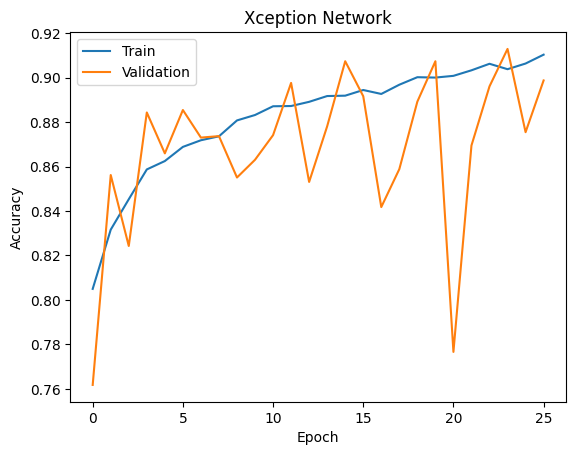

In [18]:
# plot training and validation accuracy
plt.plot(xcepModel.history.history['accuracy'])
plt.plot(xcepModel.history.history['val_accuracy'])
plt.title('Xception Phase One')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Training accuracy steadily increased where as validation accuracy had major fluctuations. 

We can see our accuracy increased overtime and we have 90+ now.

In [19]:
loss, accuracy = xcepModel.evaluate(trainImagesDS)
print("Training accuracy: {:.2f}".format(accuracy))
loss, accuracy = xcepModel.evaluate(valImagesDS)
print("Validation accuracy: {:.2f}".format(accuracy))

565/565 [==============================] - 51s 91ms/step - loss: 0.2176 - accuracy: 0.9129
Training accuracy: 0.91
141/141 [==============================] - 13s 91ms/step - loss: 0.2487 - accuracy: 0.8987
Validation accuracy: 0.90


After the evaluation we see with `21` epochs we were able to acheive accuracy of `91%` for `Training` and `90%` for Validation.

**Phase 2**

In [101]:
trainEvaluation = xcepModel.evaluate(trainImagesDS)
print(f"Training accuracy: {trainEvaluation[1]:.2f} with loss of {trainEvaluation[0]:.2f}")

valEvaluation = xcepModel.evaluate(valImagesDS)
print(f"Validation loss: {valEvaluation[1]:.2f} with Accuracy of {valEvaluation[0]:.2f}")

565/565 [==============================] - 47s 83ms/step - loss: 0.1638 - accuracy: 0.9336
Training accuracy: 0.93 with loss of 0.16
141/141 [==============================] - 12s 86ms/step - loss: 0.2185 - accuracy: 0.9176
Validation loss: 0.92 with Accuracy of 0.22


We improved the accuracy by `0.2` for both training and validation.

### Model Testing

Test conducted after second phase of training

1/1 [==============================] - 0s 19ms/step
Analysed image is 99.91% organic and 0.09% recyclable.


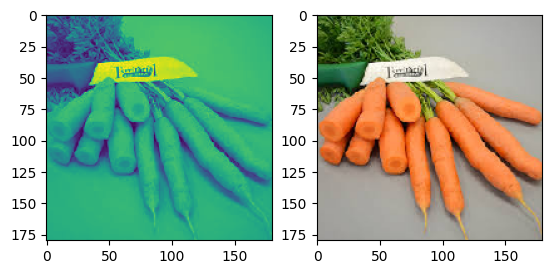

In [125]:
# Assign the image
assignImage = "/DATASET/TEST/O/O_12570.jpg"

# Load image
imgToPredict = keras.utils.load_img(assignImage, target_size=sizeOfImage)

# Plot for image
imgToPredictScaled = imgToPredict.convert('L')
plt.subplot(1, 2, 1)
plt.imshow(imgToPredictScaled)
plt.subplot(1, 2, 2)
plt.imshow(imgToPredict)
wasteImagesArray = keras.utils.img_to_array(imgToPredict)
wasteImagesArray = tf.expand_dims(wasteImagesArray, 0)

# Predict
predictImage = xcepModel.predict(wasteImagesArray)

# Evaluate
score = float(keras.activations.sigmoid(predictImage[0, 0]))
print(f"Analysed image is {100 * (1 - score):.2f}% organic and {100 * score:.2f}% recyclable.")

Model predicted items/objects in above image are 99.91% organic and 0.09% recycle. In my opinion, that is remarkable result we can agree on most of it wherer personally would like to put it this way; Carrots are 99.91% organic and knife is the remaining 0.09%.

## Conclusion

Overall, the performance of Xception network is good and with more training the accuracy can be improved, also Grad-CAM class activation can be added to further understand the neurons activation. Further enchancement can be done such as integration of live object recognition to help people with waste management accurately and smartly, better than before. 

After developing this program, concepts were cleared and understanding of CNN improved. Also, processing image data is pretty interesting, further processing can also be done to generate more samples in order to leave zero chance for overfitting.

## Inspiration & Learning Resources

Below resources were utilized to fine tune the model and clear concepts

[MIT 6.S191: Convolutional Neural Networks](https://www.youtube.com/watch?v=NmLK_WQBxB4)

[MIT 6.S191: Deep Generative Modeling](https://www.youtube.com/watch?v=3G5hWM6jqPk)

# References

Oliveira, A. (2023) The role of mixed waste sorting towards improved circularity of resources, Zero Waste Europe. Available at: https://zerowasteeurope.eu/2023/05/the-role-of-mixed-waste-sorting-towards-improved-circularity-of-resources/ (Accessed: 20 December 2023). 

Data augmentation&nbsp; :&nbsp;  Tensorflow Core (no date) TensorFlow. Available at: https://www.tensorflow.org/tutorials/images/data_augmentation (Accessed: 20 December 2023). 

Team, K. (no date) Keras Documentation: Xception, Keras. Available at: https://keras.io/api/applications/xception/ (Accessed: 20 December 2023). 

K.a. (2019) The influence of data scaling on machine learning algorithms, Medium. Available at: https://towardsdatascience.com/the-influence-of-data-scaling-on-machine-learning-algorithms-fbee9181d497 (Accessed: 20 December 2023). 

(2017) Xception: Deep learning with depthwise separable convolutions. Available at: https://openaccess.thecvf.com/content_cvpr_2017/papers/Chollet_Xception_Deep_Learning_CVPR_2017_paper.pdf (Accessed: 20 December 2023). 